[https://sinhrks.hatenablog.com/entry/2016/01/23/213333](https://sinhrks.hatenablog.com/entry/2016/01/23/213333)

逆行列を並列化させる

# ブロック形式ガウスmethod

ブロック形式ガウス法では入力となる行列をいくつかのブロックに区切り、ブロックごとに処理を行う。具体的には、左上の対角ブロックからはじめて、以下の順番で処理していく。

1. 対角ブロックの計算
2. 1と同じ行のブロックの計算
3. 1と同じ列のブロックの計算
4. 一つ右下の対角ブロックへ

処理の順序を図示すると以下のような形。行/列の処理 (2, 3) は順序関係ないため入れ替えてもよい = 並列に処理できる。

<img src="img_document/block_gauss.png">

ブロック内の計算は 通常の (ブロック化しない) LU 分解や、基本的な行列演算の組み合わせで書ける。

上の PDF 資料では 3 ブロック目以降の式がよくわからないため、i 行 j 列目のブロックを Aij として計算式を書いておく。Python での実装を考慮して、逆行列ではなく scipy.linalg.solve (実際に使うのは solve_triangular ) を使って書く。

In [1]:
import numpy as np
import scipy
import scipy.linalg

np.__version__
# '1.10.2'

# 表示を丸め
np.set_printoptions(precision=2)

scipy.__version__
# '0.16.1'

'1.7.2'

In [2]:
A = np.array([[  9.,   3.,   7.,   8.,   8.,  10.,   3.,   8.,   6.],
              [  2.,  10.,  10.,   1.,   8.,   3.,   7.,   4.,   8.],
              [  7.,   8.,   1.,   5.,   7.,   9.,   5.,   9.,   2.],
              [  1.,   8.,   6.,   6.,  10.,   7.,   7.,   9.,   3.],
              [  8.,   8.,  10.,   9.,   5.,   3.,   7.,   5.,   4.],
              [  1.,   4.,   3.,   4.,   3.,  10.,   3.,   2.,   1.],
              [  4.,   1.,   6.,   5.,   4.,   9.,  10.,   6.,   9.],
              [  6.,   9.,   2.,   3.,   8.,   1.,   9.,   4.,   2.],
              [  8.,   6.,   2.,   9.,   8.,   9.,   3.,  10.,   8.]])
A

array([[ 9.,  3.,  7.,  8.,  8., 10.,  3.,  8.,  6.],
       [ 2., 10., 10.,  1.,  8.,  3.,  7.,  4.,  8.],
       [ 7.,  8.,  1.,  5.,  7.,  9.,  5.,  9.,  2.],
       [ 1.,  8.,  6.,  6., 10.,  7.,  7.,  9.,  3.],
       [ 8.,  8., 10.,  9.,  5.,  3.,  7.,  5.,  4.],
       [ 1.,  4.,  3.,  4.,  3., 10.,  3.,  2.,  1.],
       [ 4.,  1.,  6.,  5.,  4.,  9., 10.,  6.,  9.],
       [ 6.,  9.,  2.,  3.,  8.,  1.,  9.,  4.,  2.],
       [ 8.,  6.,  2.,  9.,  8.,  9.,  3., 10.,  8.]])

<img src="img_document/matrix.png">

まずは ブロック化せずに LU 分解の結果を確かめる。LU 分解は scipy.linalg.lu で行うことができ、返り値は P, L, U の 3 つの ndarray となる。

P は置換行列で、LU 分解時のピボット (行の入れ替え) 処理に対応する。今回は P が単位行列になっているため、ピボットなしで分解できていることがわかる。

In [3]:
P, L, U = scipy.linalg.lu(A)
P

array([[1., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 1., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 1., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 1., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 1., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 1., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 1., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 1., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 1.]])

In [4]:
L, U

(array([[ 1.  ,  0.  ,  0.  ,  0.  ,  0.  ,  0.  ,  0.  ,  0.  ,  0.  ],
        [ 0.22,  1.  ,  0.  ,  0.  ,  0.  ,  0.  ,  0.  ,  0.  ,  0.  ],
        [ 0.78,  0.61,  1.  ,  0.  ,  0.  ,  0.  ,  0.  ,  0.  ,  0.  ],
        [ 0.11,  0.82,  0.18,  1.  ,  0.  ,  0.  ,  0.  ,  0.  ,  0.  ],
        [ 0.89,  0.57,  0.11,  0.41,  1.  ,  0.  ,  0.  ,  0.  ,  0.  ],
        [ 0.11,  0.39,  0.11,  0.6 ,  0.37,  1.  ,  0.  ,  0.  ,  0.  ],
        [ 0.44, -0.04, -0.33,  0.2 ,  0.17,  0.61,  1.  ,  0.  ,  0.  ],
        [ 0.67,  0.75,  0.94, -0.18, -0.23, -0.92,  0.35,  1.  ,  0.  ],
        [ 0.89,  0.36,  0.76,  0.46,  0.16, -0.2 , -0.23,  0.03,  1.  ]]),
 array([[ 9.  ,  3.  ,  7.  ,  8.  ,  8.  , 10.  ,  3.  ,  8.  ,  6.  ],
        [ 0.  ,  9.33,  8.44, -0.78,  6.22,  0.78,  6.33,  2.22,  6.67],
        [ 0.  ,  0.  , -9.57, -0.75, -3.  ,  0.75, -1.18,  1.43, -6.71],
        [ 0.  ,  0.  ,  0.  ,  5.88,  4.54,  5.12,  1.68,  6.03, -1.94],
        [ 0.  ,  0.  ,  0.  ,  0.  , -7.2 , -8.52

In [5]:
def block_slice(m, i, j, size=3):
    return m[i*size:(i+1)*size, j*size:(j+1)*size]

# 0 行 0 列目
A00 = block_slice(A, 0, 0)
A00 

array([[ 9.,  3.,  7.],
       [ 2., 10., 10.],
       [ 7.,  8.,  1.]])

左上のブロック A00はそのまま LU 分解すればよい。LU 分解には scipy.linalg.lu を使う。1 番目の返り値である P は単位行列となるため無視する。

In [6]:
_, L00, U00 = scipy.linalg.lu(A00)
L00
# array([[ 1.  ,  0.  ,  0.  ],
#        [ 0.22,  1.  ,  0.  ],
#        [ 0.78,  0.61,  1.  ]])

# 結果が一致するか確認。以降の出力は適宜省略
assert np.allclose(L00, block_slice(L, 0, 0))
assert np.allclose(U00, block_slice(U, 0, 0))

0 行目ならびに 0 列目では 上式の総和にあたる部分がないため、単に L00x=A01 , L00x=A02を解けばよい。L00 は下三角行列であることから scipy.linalg.solve_triangular で解ける。



In [7]:
# 0 行 1 列目
A01 = block_slice(A, 0, 1)
U01 = scipy.linalg.solve_triangular(L00, A01, lower=True)
U01
# array([[  8.  ,   8.  ,  10.  ],
#        [ -0.78,   6.22,   0.78],
#        [ -0.75,  -3.  ,   0.75]])

# 0 行 2 列目
A02 = block_slice(A, 0, 2)
U02 = scipy.linalg.solve_triangular(L00, A02, lower=True)

assert np.allclose(U01, block_slice(U, 0, 1))
assert np.allclose(U02, block_slice(U, 0, 2))

同じ列のブロックの計算

In [8]:
# 1 行 0 列目
A10 = block_slice(A, 1, 0)
L10 = scipy.linalg.solve_triangular(U00.T, A10.T, lower=True).T
L10
# array([[ 0.11,  0.82,  0.18],
#        [ 0.89,  0.57,  0.11],
#        [ 0.11,  0.39,  0.11]])

# 2 行 0 列目
A20 = block_slice(A, 2, 0)
L20 = scipy.linalg.solve_triangular(U00.T, A20.T, lower=True).T

assert np.allclose(L10, block_slice(L, 1, 0))
assert np.allclose(L20, block_slice(L, 2, 0))

ひとつ右下の対角ブロックへ

In [9]:
# 1 行 1 列目
A11 = block_slice(A, 1, 1)
_, L11, U11 = scipy.linalg.lu(A11 - L10.dot(U01))
L11
# array([[ 1.  ,  0.  ,  0.  ],
#        [ 0.41,  1.  ,  0.  ],
#        [ 0.6 ,  0.37,  1.  ]])

assert np.allclose(L11, block_slice(L, 1, 1))
assert np.allclose(U11, block_slice(U, 1, 1))

以降、上式と同じ処理を続ける。

In [10]:
# 1 行 2 列目
A12 = block_slice(A, 1, 2)
U12 = scipy.linalg.solve_triangular(L11, A12 - L10.dot(U02), lower=True)
assert np.allclose(U12, block_slice(U, 1, 2))

# 2 行 1 列目
A21 = block_slice(A, 2, 1)
L21 = scipy.linalg.solve_triangular(U11.T, (A21 - L20.dot(U01)).T, lower=True).T
assert np.allclose(L21, block_slice(L, 2, 1))

# 2 行 2 列目
A22 = block_slice(A, 2, 2)
_, L22, U22 = scipy.linalg.lu(A22 - L20.dot(U02) - L21.dot(U12))
L22
# array([[ 1.  ,  0.  ,  0.  ],
#        [ 0.35,  1.  ,  0.  ],
#        [-0.23,  0.03,  1.  ]])

assert np.allclose(L22, block_slice(L, 2, 2))
assert np.allclose(U22, block_slice(U, 2, 2))

Dask では計算処理を以下のような DAG で定義する。定義したグラフは Dask のスケジューラによって自動的に Out-Of-Core / 並列処理される。ブロック形式ガウス法では行/列の処理 (2, 3) や、各ブロック内での計算中に出てくる行列積は 順序関係ないため並列で実行できる。

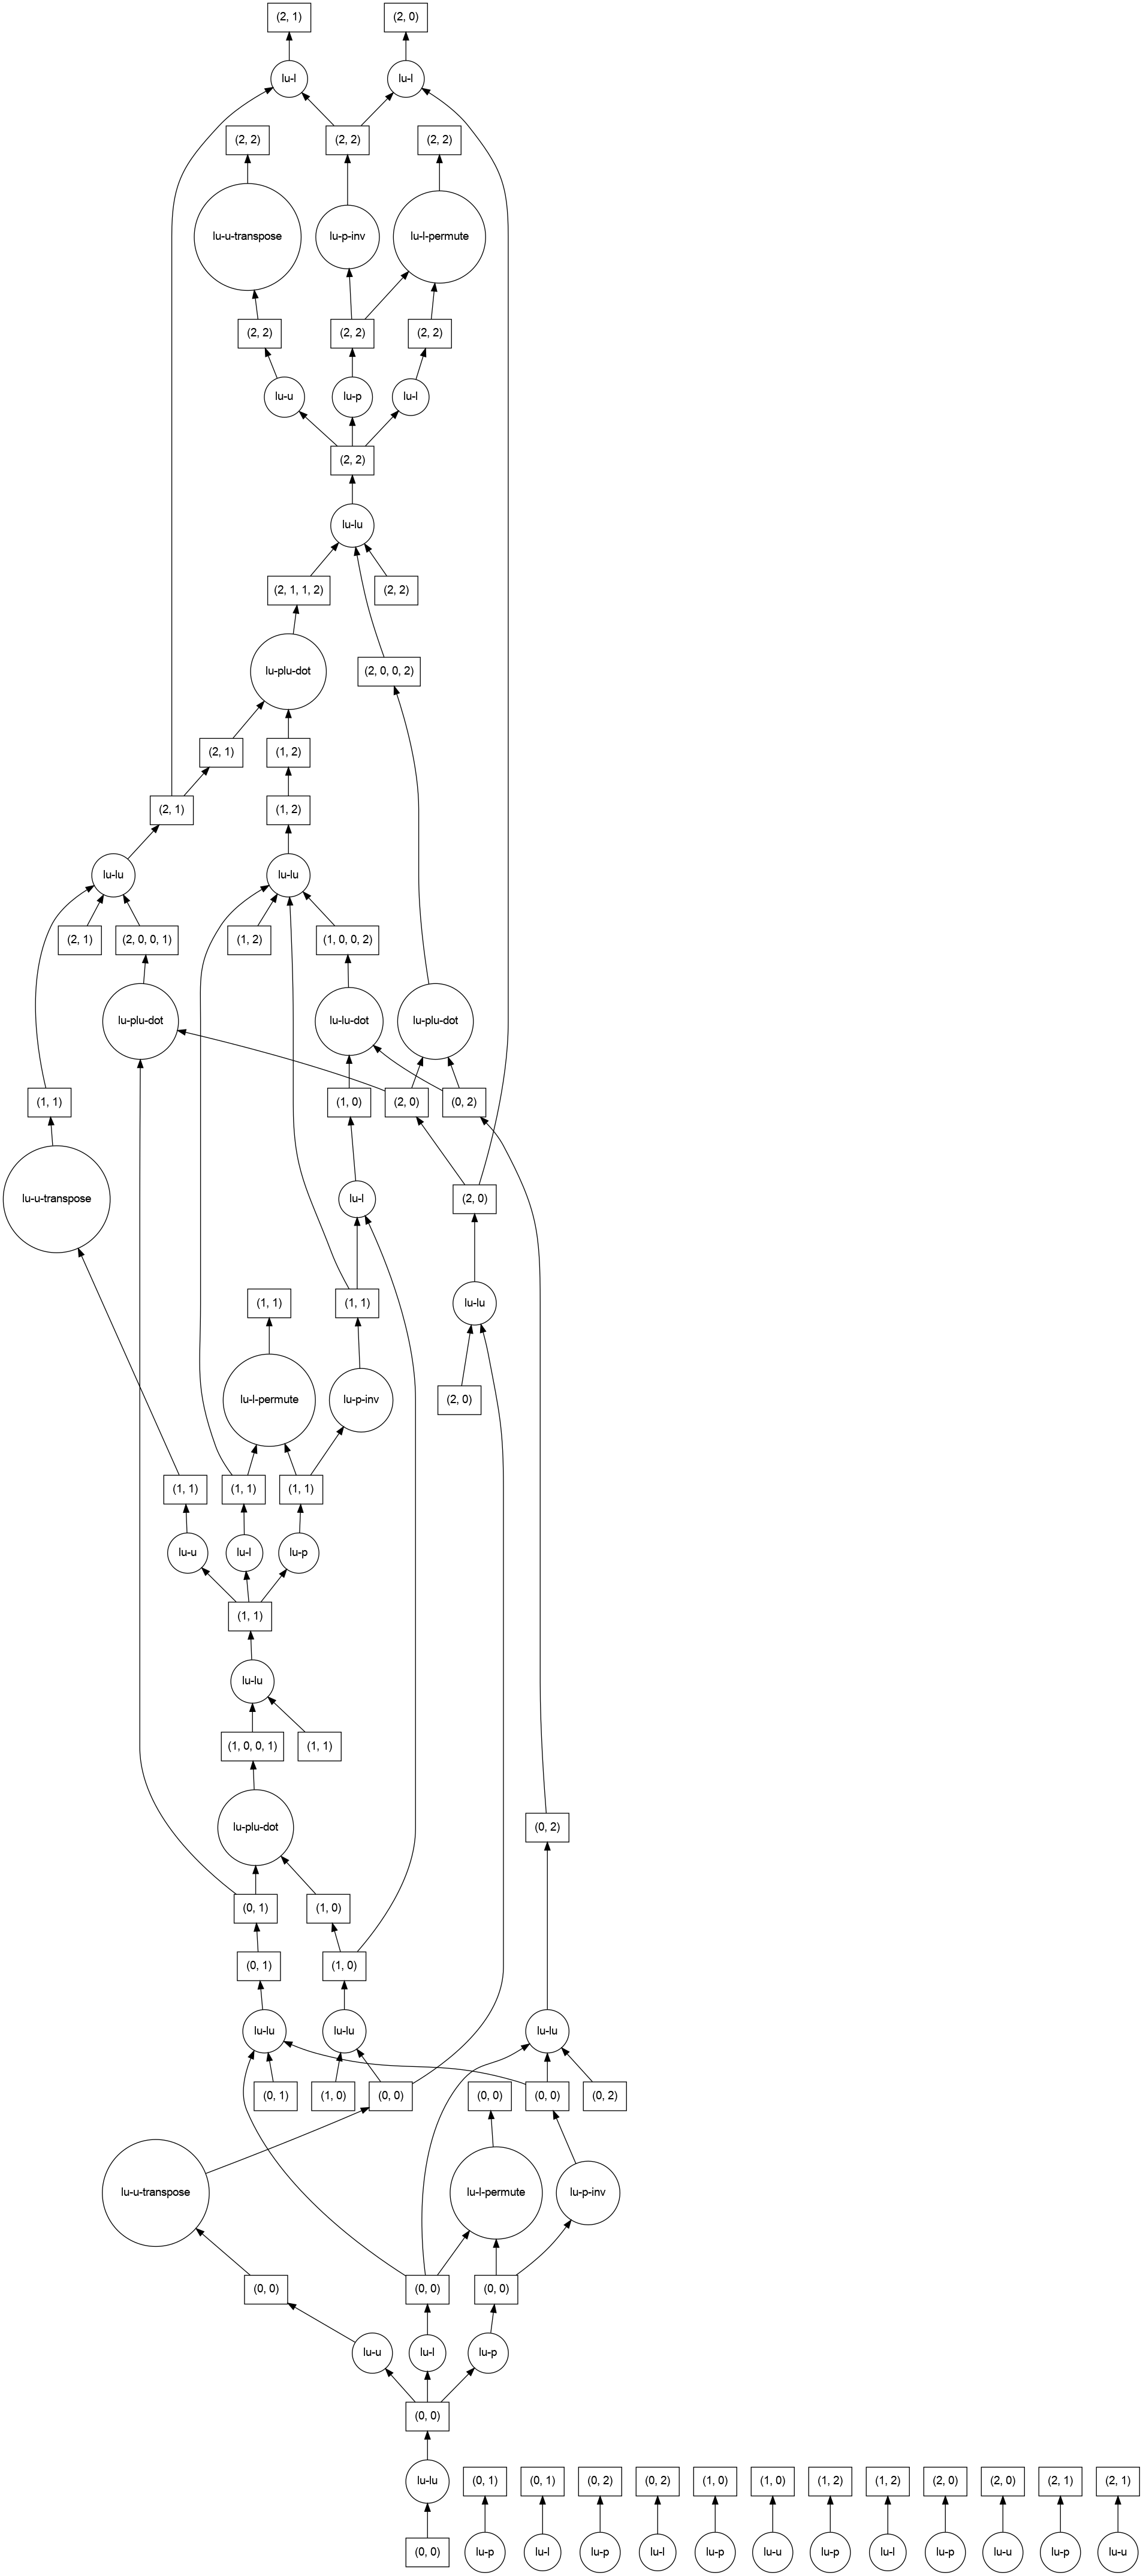

In [11]:
# 利用するには1/23以降のmaster (公式には 0.7.6 の次のバージョン) が必要
import dask.array as da
dA = da.from_array(A, (3, 3))
dP, dL, dU = da.linalg.lu(dA)
assert np.allclose(dL.compute(), L) 
assert np.allclose(dU.compute(), U) 
# 結果は上と同一のため略

dL.visualize()
# dL.dask

In [21]:
large_n = 1000
A = np.random.random((large_n, large_n))
dA = da.from_array(A)


In [22]:
%%time
npAinv = np.linalg.pinv(A)


CPU times: user 3.44 s, sys: 5.35 s, total: 8.79 s
Wall time: 635 ms


In [23]:
%%time
daAinv = da.linalg.inv(dA)

CPU times: user 0 ns, sys: 36.2 ms, total: 36.2 ms
Wall time: 2.43 ms


In [ ]:
assert np.allclose(npAinv, daAinv)